# Notebook to evaluate the activity model

This notebook is designed as an evaluation notebook.

In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import time
import os
import ants
import pandas as pd
import statsmodels.api as smapi
import numpy as np
from nibabel import load as load_nii
from nibabel import Nifti1Image
from skimage.filters import threshold_otsu
from skimage.measure import label as bwlabeln
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage.morphology import binary_closing
from scipy.ndimage.morphology import binary_fill_holes
from scipy.stats import ttest_rel, normaltest
from scipy.stats import spearmanr, kendalltau
from shutil import copyfile
import seaborn as sns

## Utility functions
### Statistics

In [2]:
def plot_correlation(metrics, network, lowess=False):
    model_vols = [m[5] for m in metrics['positive'] if m[1] == network]
    manual_vols = [m[6] for m in metrics['positive'] if m[1] == network]
    model_lesions = [m[10] for m in metrics['positive'] if m[1] == network]
    manual_lesions = [m[11] for m in metrics['positive'] if m[1] == network]
    array = [
        [
            (m[6] - np.mean(manual_vols)) / np.std(manual_vols),
            (m[5] - np.mean(model_vols)) / np.std(model_vols),
            'Volume'
        ]
        for m in metrics['positive'] if m[1] == network
    ] + [
        [
            (m[11] - np.mean(manual_lesions)) / np.std(manual_lesions),
            (m[10] - np.mean(model_lesions)) / np.std(model_lesions),
            'Lesions'
        ]
        for m in metrics['positive'] if m[1] == network
    ]

    columns = [
        'Manual',
        'Model',
        'Value per patient'
    ]
    dataframe = pd.DataFrame(array, columns=columns)

    snd_handle = sns.lmplot(
        x='Model', y='Manual', data=dataframe, hue='Value per patient',
        ci=68, truncate=False, lowess=lowess, robust=(not lowess)
    ) 
    
    lesions_dataframe = dataframe[dataframe['Value per patient'] == 'Lesions']
    x = lesions_dataframe['Model'].to_numpy()
    y = lesions_dataframe['Manual'].to_numpy()
    
    x[np.isnan(x)] = 0
    y[np.isnan(y)] = 0
    
    results_lesions = smapi.OLS(y, smapi.add_constant(x)).fit()
    spr_lesions, _ = spearmanr(x, y)
    
    volume_dataframe = dataframe[dataframe['Value per patient'] == 'Volume']
    x = volume_dataframe['Model'].to_numpy()
    y = volume_dataframe['Manual'].to_numpy()
    
    x[np.isnan(x)] = 0
    y[np.isnan(y)] = 0
    
    results_volume = smapi.OLS(y, smapi.add_constant(x)).fit()
    spr_volume, _ = spearmanr(x, y)

    if lowess:
        plt.title(
            u'{:} Lesions [\u03C1 = {:5.3f}] / Volume [\u03C1 = {:5.3f}]'.format(
                network, spr_lesions, spr_volume     
            )
        )
    else:
        plt.title(
            u'{:} Lesions [R\u00b2 = {:5.3f}] / Volume [R\u00b2 = {:5.3f}]'.format(
                network,
                results_lesions.rsquared,
                results_volume.rsquared     
            )
        )
    snd_handle.fig.subplots_adjust(top=.95, bottom=.1)

### Others

In [3]:
def get_int(string):
    """
    Function to get the int number contained in a string. If there are more
    than one int number (or there is a floating point number), this function
    will concatenate all digits and return an int, anyways.
    :param string: String that contains an int number
    :return: int number
    """
    return int(''.join(filter(str.isdigit, string)))


def get_dirs(path):
    """
    Function to get the folder name of the patients given a path.
    :param path: Folder where the patients should be located.
    :return: List of patient names.
    """
    # All patients (full path)
    patient_paths = sorted(
        filter(
            lambda d: os.path.isdir(os.path.join(path, d)),
            os.listdir(path)
        )
    )
    # Patients used during training
    return patient_paths

## Data loading

In [4]:
path = '/media/transcend/MSReports/Longitudinal/MICCAI_Challenge2021/training/'
cases = [
    p for p in sorted(os.listdir(path))
    if os.path.isdir(os.path.join(path, p))
]
print(cases)

['013', '015', '016', '018', '019', '020', '021', '024', '026', '027', '029', '030', '032', '035', '037', '039', '043', '047', '048', '049', '051', '052', '057', '061', '068', '069', '070', '074', '077', '083', '084', '088', '089', '090', '091', '094', '095', '096', '099', '100']


In [5]:
positive_cases = []
negative_cases = []
for p in cases:
    p_path = os.path.join(path, p)
    print('\033[KChecking {:}'.format(p_path), end='\r')
    gt_bool = load_nii(
        os.path.join(p_path, 'ground_truth.nii.gz')
    ).get_fdata().astype(bool)
    if np.sum(gt_bool) > 0:
        positive_cases.append(p)
    else:
        negative_cases.append(p)
print('Positive cases', positive_cases)
print('Negative cases', negative_cases)

Positive cases ['013', '016', '018', '020', '021', '024', '026', '027', '029', '030', '032', '035', '037', '039', '043', '047', '048', '057', '061', '069', '074', '077', '083', '088', '091', '094', '095', '099', '100']
Negative cases ['015', '019', '049', '051', '052', '068', '070', '084', '089', '090', '096']


## Metrics

### Loading and data preparation

In [6]:
all_metrics = {
    'positive': [],
    'negative': []
}
manual_vols = []
model_vols = []
manual_lesions = []
model_lesions = []
positive_metrics = [
    'Patient', 'Network',
    'TPF (V)', 'FPF (V)', 'DSC', 'TP (V)', 'V','GT (V)',
    'TPF (D)', 'FPF (D)', 'TP (D)', 'D', 'GT (D)', 'TP (C)'
]
negative_metrics = [
    'Patient', 'Network',
    'FP (V)', 'FP (D)', 'FP (C)'
]
training_labels = {
    '': 'Baseline',
    '_ft': 'Fine-tuning',
    '_ft-freeze': 'Fine-tuning (frozen)',
    '_init': 'Trained (private)',
    '_xval': 'Trained'
}
with open(
        os.path.join(path, 'activity_metrics.csv'), 'w'
) as csvfile:
    evalwriter = csv.writer(csvfile)
    evalwriter.writerow(positive_metrics)
    for p in cases:
        p_path = os.path.join(path, p)
        print('\033[KChecking {:}'.format(p_path), end='\r')
        gt_bool = load_nii(
            os.path.join(p_path, 'ground_truth.nii.gz')
        ).get_fdata().astype(bool)
        gt_lab = bwlabeln(gt_bool)
        gt_v = np.sum(gt_bool)
        gt_d = len(np.unique(gt_lab[gt_lab > 0]))
        gtc = gt_v > 0
        
        for tr_key, tr_value in training_labels.items():
            auto_name = os.path.join(
                p_path, 'positive_activity{:}.nii.gz'.format(tr_key)
            )
            auto_bool = load_nii(auto_name).get_fdata().astype(bool)
            auto_lab = bwlabeln(auto_bool)
            auto_labs = np.unique(auto_lab)
            
            v = np.sum(auto_bool)

            # Positive cases
            if gtc:
                # Some intermediate steps.
                overlap = np.logical_and(gt_bool, auto_bool)
                nonoverlap = np.logical_and(np.logical_not(gt_bool), auto_bool)
                               
                # Pretty common and normal voxelwise / segmentation metrics.
                sum_v = v + gt_v
                
                tp_v = np.sum(overlap)
                tpf_v = tp_v / gt_v if gt_v > 0 else 0
                fp_v = np.sum(nonoverlap)
                fpf_v = fp_v / v if v > 0 else 0
                dsc = 2 * tp_v / sum_v if sum_v > 0 else 0

                # And finally a few regionwise / detection metrics.
                tp_labs = np.unique(gt_lab[auto_bool])
                notfp_labs = np.unique(auto_lab[gt_bool])
                fp_mask = np.logical_not(np.isin(auto_lab, notfp_labs))
                fp_labs = np.unique(auto_lab[fp_mask])
                tp = len(tp_labs[tp_labs > 0])
                tp_d = len(tp_labs[tp_labs > 0])
                fp = len(fp_labs[fp_labs > 0])
                tpf_d = 100 * tp / gt_d if gt_d > 0 else 0
                d = len(np.unique(auto_lab[auto_lab > 0]))
                fpf_d = 100 * fp / d if d > 0 else 0

                tpc = v > 0

                all_metrics['positive'].append([
                    p, tr_value, tpf_v, fpf_v, dsc, tp_v, v, gt_v,
                    tpf_d, fpf_d, tp_d, d, gt_d, tpc
                ])
                evalwriter.writerow([
                    p, tr_value, tpf_v, fpf_v, dsc, tp_v, v, gt_v,
                    tpf_d, fpf_d, tp_d, d, gt_d, tpc
                ])
            else:
                # And finally a few regionwise / detection metrics.
                fp_d = len(auto_labs[auto_labs > 0])
                fp_c = fp_d > 0
                fp_v = v

                all_metrics['negative'].append([
                    p, tr_value, fp_v, fp_d, fp_c
                ])

### Patient-based metrics

In [7]:
pd.DataFrame(all_metrics['positive'], columns=positive_metrics)

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
0,013,Baseline,0.650000,0.587302,0.504854,26,63,40,100.0,50.000000,1,2,1,True
1,013,Fine-tuning,0.750000,0.655172,0.472441,30,87,40,100.0,50.000000,1,2,1,True
2,013,Fine-tuning (frozen),0.825000,0.736000,0.400000,33,125,40,100.0,80.000000,1,5,1,True
3,013,Trained (private),0.850000,0.679245,0.465753,34,106,40,100.0,66.666667,1,3,1,True
4,013,Trained,0.750000,0.651163,0.476190,30,86,40,100.0,50.000000,1,2,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,100,Baseline,0.530837,0.020325,0.688571,482,492,908,100.0,33.333333,2,3,2,True
141,100,Fine-tuning,0.714758,0.175349,0.765782,649,787,908,100.0,66.666667,2,6,2,True
142,100,Fine-tuning (frozen),0.731278,0.161616,0.781176,664,792,908,100.0,77.777778,2,9,2,True
143,100,Trained (private),0.659692,0.130624,0.750157,599,689,908,100.0,60.000000,2,5,2,True


In [8]:
positive_df = pd.DataFrame(all_metrics['positive'], columns=positive_metrics)
positive_df[positive_df['DSC'] < 0.6]

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
0,013,Baseline,0.650000,0.587302,0.504854,26,63,40,100.0,50.000000,1,2,1,True
1,013,Fine-tuning,0.750000,0.655172,0.472441,30,87,40,100.0,50.000000,1,2,1,True
2,013,Fine-tuning (frozen),0.825000,0.736000,0.400000,33,125,40,100.0,80.000000,1,5,1,True
3,013,Trained (private),0.850000,0.679245,0.465753,34,106,40,100.0,66.666667,1,3,1,True
4,013,Trained,0.750000,0.651163,0.476190,30,86,40,100.0,50.000000,1,2,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,094,Trained (private),0.472501,0.728113,0.345161,1177,4329,2491,100.0,87.500000,5,56,5,True
129,094,Trained,0.097953,0.816679,0.127682,244,1331,2491,60.0,87.500000,3,24,5,True
135,099,Baseline,0.301205,0.000000,0.462963,25,25,83,100.0,0.000000,1,1,1,True
137,099,Fine-tuning (frozen),0.626506,0.469388,0.574586,52,98,83,100.0,66.666667,1,3,1,True


In [9]:
positive_df[(positive_df['Network'] == 'Trained (private)') | (positive_df['Network'] == 'Baseline')]
trained_df = positive_df[positive_df['Network'] == 'Trained (private)']
baseline_df = positive_df[positive_df['Network'] == 'Baseline']

trained_patients = []
baseline_patients = []

for (trained_idx, trained_row), (baseline_idx, baseline_row) in zip(trained_df.iterrows(), baseline_df.iterrows()):
    if trained_row['DSC'] > baseline_row['DSC']:
        trained_patients.append(trained_row['Patient'])
    else:
        baseline_patients.append(trained_row['Patient'])

In [10]:
trained_df[trained_df['Patient'].isin(trained_patients)]

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
13,018,Trained (private),0.310440,0.073770,0.465021,113,122,364,100.000000,0.000000,2,2,2,True
18,020,Trained (private),0.731343,0.505051,0.590361,147,297,201,100.000000,88.888889,1,9,1,True
23,021,Trained (private),0.728783,0.304627,0.711686,1623,2334,2227,100.000000,63.636364,4,11,4,True
28,024,Trained (private),0.847795,0.183562,0.831821,596,730,703,100.000000,40.000000,6,10,6,True
33,026,Trained (private),0.558511,0.322581,0.612245,210,310,376,77.777778,36.363636,7,11,9,True
38,027,Trained (private),0.695940,0.127811,0.774160,737,845,1059,100.000000,33.333333,4,6,4,True
43,029,Trained (private),0.006234,0.910714,0.011655,5,56,802,50.000000,75.000000,1,4,2,True
68,039,Trained (private),0.379566,0.052973,0.541928,4666,4927,12293,92.307692,25.000000,12,16,13,True
73,043,Trained (private),0.253188,0.318627,0.369190,139,204,549,50.000000,50.000000,2,4,4,True
78,047,Trained (private),0.416667,0.891775,0.171821,25,231,60,100.000000,90.000000,1,10,1,True


In [11]:
baseline_df[~baseline_df['Patient'].isin(baseline_patients)]

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
10,018,Baseline,0.049451,0.000000,0.094241,18,18,364,50.000000,0.000000,1,1,2,True
15,020,Baseline,0.522388,0.447368,0.537084,105,190,201,100.000000,50.000000,1,2,1,True
20,021,Baseline,0.612034,0.231680,0.681330,1363,1774,2227,100.000000,33.333333,4,6,4,True
25,024,Baseline,0.681366,0.064453,0.788477,479,512,703,83.333333,0.000000,5,5,6,True
30,026,Baseline,0.385638,0.152047,0.530165,145,171,376,44.444444,20.000000,4,5,9,True
35,027,Baseline,0.521246,0.029877,0.678133,552,569,1059,100.000000,0.000000,4,4,4,True
40,029,Baseline,0.000000,0.000000,0.000000,0,0,802,0.000000,0.000000,0,0,2,False
65,039,Baseline,0.285447,0.025548,0.441550,3509,3601,12293,69.230769,0.000000,9,12,13,True
70,043,Baseline,0.200364,0.320988,0.309423,110,162,549,25.000000,50.000000,1,2,4,True
75,047,Baseline,0.100000,0.975806,0.038961,6,248,60,100.000000,85.714286,1,7,1,True


In [12]:
trained_df[~trained_df['Patient'].isin(trained_patients)]

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
3,013,Trained (private),0.850000,0.679245,0.465753,34,106,40,100.000000,66.666667,1,3,1,True
8,016,Trained (private),0.686406,0.200627,0.738595,510,638,743,83.333333,37.500000,5,8,6,True
48,030,Trained (private),0.817021,0.451429,0.656410,576,1050,705,100.000000,78.571429,3,14,3,True
53,032,Trained (private),0.000000,1.000000,0.000000,0,50,53,0.000000,100.000000,0,2,1,True
58,035,Trained (private),0.778506,0.484375,0.620366,594,1152,763,100.000000,75.000000,4,16,4,True
63,037,Trained (private),1.000000,0.720000,0.437500,21,75,21,100.000000,75.000000,1,4,1,True
103,074,Trained (private),0.732673,0.267327,0.732673,814,1111,1111,88.888889,52.941176,8,17,9,True
108,077,Trained (private),0.633333,0.155556,0.723810,114,135,180,100.000000,50.000000,1,2,1,True
118,088,Trained (private),0.000000,0.000000,0.000000,0,0,104,0.000000,0.000000,0,0,1,False


In [13]:
baseline_df[baseline_df['Patient'].isin(baseline_patients)]

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
0,013,Baseline,0.650000,0.587302,0.504854,26,63,40,100.000000,50.000000,1,2,1,True
5,016,Baseline,0.631225,0.078585,0.749201,469,509,743,83.333333,0.000000,5,5,6,True
45,030,Baseline,0.693617,0.199673,0.743161,489,611,705,100.000000,50.000000,3,6,3,True
50,032,Baseline,0.000000,1.000000,0.000000,0,2,53,0.000000,100.000000,0,1,1,True
55,035,Baseline,0.689384,0.329082,0.680026,526,784,763,75.000000,62.500000,3,8,4,True
60,037,Baseline,0.952381,0.000000,0.975610,20,20,21,100.000000,0.000000,1,1,1,True
100,074,Baseline,0.666967,0.111511,0.761954,741,834,1111,88.888889,11.111111,8,9,9,True
105,077,Baseline,0.583333,0.027778,0.729167,105,108,180,100.000000,0.000000,1,1,1,True
115,088,Baseline,0.000000,0.000000,0.000000,0,0,104,0.000000,0.000000,0,0,1,False


### Mean metrics

In [16]:
positive_df = pd.DataFrame(all_metrics['positive'], columns=positive_metrics)
positive_df.groupby('Network', sort=False).mean()

,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
Network,,,,,,,,,,,,
Baseline,0.447054,0.241587,0.505466,993.517241,1341.034483,2049.37931,75.842728,29.119513,3.931034,8.344828,5.206897,0.931034
Fine-tuning,0.605700,0.447869,0.510513,1310.172414,2197.517241,2049.37931,90.000553,61.056246,4.482759,18.586207,5.206897,0.965517
Fine-tuning (frozen),0.619036,0.483119,0.506116,1400.482759,2455.758621,2049.37931,86.552277,67.604448,4.655172,19.689655,5.206897,1.000000
Trained (private),0.576441,0.350733,0.554461,1223.758621,1560.827586,2049.37931,86.193081,52.047803,4.586207,11.586207,5.206897,0.965517
Trained,0.427942,0.309784,0.466699,876.206897,1092.379310,2049.37931,72.393899,40.843596,4.103448,7.931034,5.206897,0.931034


In [17]:
positive_df[positive_df['DSC'] > 0.6].groupby('Network', sort=False).mean()

,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
Network,,,,,,,,,,,,
Baseline,0.649356,0.095513,0.749590,1605.642857,1772.857143,2678.000000,91.542659,17.702914,5.000000,6.571429,5.714286,True
Fine-tuning,0.723170,0.209947,0.739398,2371.357143,2801.500000,3587.428571,95.755113,48.448700,6.428571,12.714286,7.285714,True
Fine-tuning (frozen),0.743658,0.219579,0.751229,2742.538462,3227.384615,3857.000000,96.069609,52.621006,7.230769,14.615385,7.769231,True
Trained (private),0.726745,0.205426,0.750673,1806.533333,2080.533333,2528.666667,96.041667,46.414324,5.466667,10.733333,5.933333,True
Trained,0.658192,0.179928,0.713557,1188.384615,1336.769231,2197.923077,93.856838,32.060440,5.153846,8.000000,5.846154,True


In [18]:
positive_df[positive_df['DSC'] > 0.6].groupby('Network', sort=False).sum()

,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
Network,,,,,,,,,,,,
Baseline,9.090979,1.337179,10.494254,22479,24820,37492,1281.597222,247.840803,70,92,80,14
Fine-tuning,10.124375,2.939253,10.351577,33199,39221,50224,1340.571581,678.281806,90,178,102,14
Fine-tuning (frozen),9.667560,2.854533,9.765980,35653,41956,50141,1248.904915,684.073084,94,190,101,13
Trained (private),10.901170,3.081389,11.260097,27098,31208,37930,1440.625000,696.214860,82,161,89,15
Trained,8.556499,2.339059,9.276238,15449,17378,28573,1220.138889,416.785714,67,104,76,13


In [19]:
negative_df = pd.DataFrame(all_metrics['negative'], columns=negative_metrics)
negative_df.groupby('Network', sort=False).mean()

,FP (V),FP (D),FP (C)
Network,,,
Baseline,5.545455,0.272727,0.272727
Fine-tuning,166.636364,11.000000,1.000000
Fine-tuning (frozen),224.636364,12.000000,0.909091
Trained (private),46.545455,3.727273,0.636364
Trained,59.181818,3.727273,0.454545


### Correlations

<IPython.core.display.Javascript object>


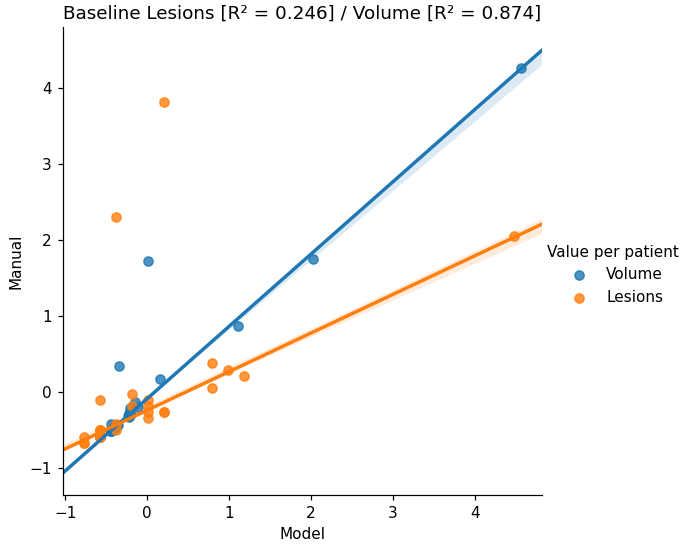

<IPython.core.display.Javascript object>


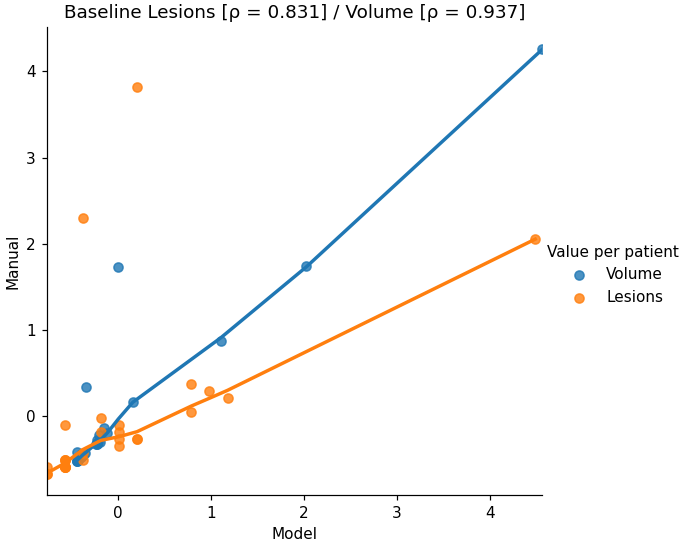

<IPython.core.display.Javascript object>


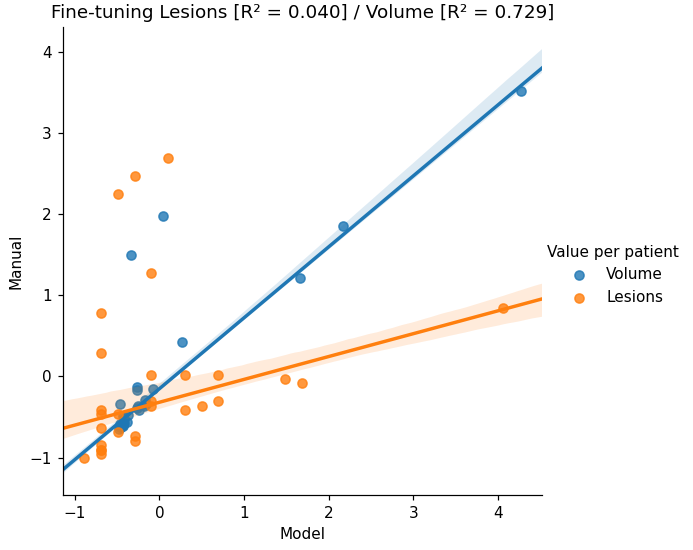

<IPython.core.display.Javascript object>


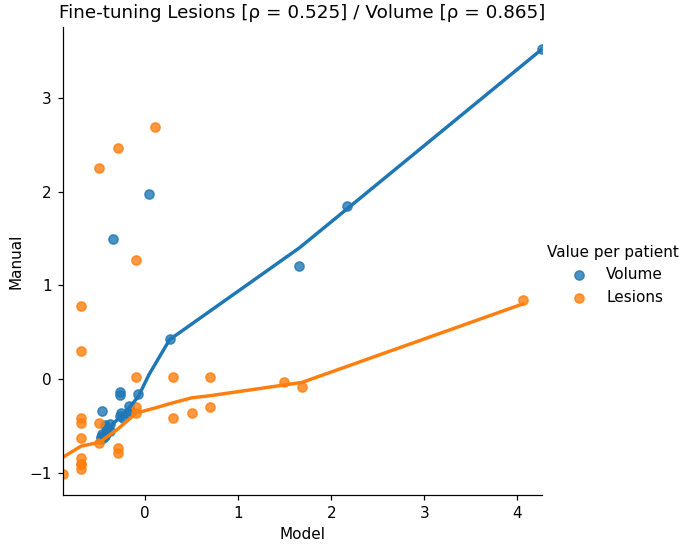

<IPython.core.display.Javascript object>


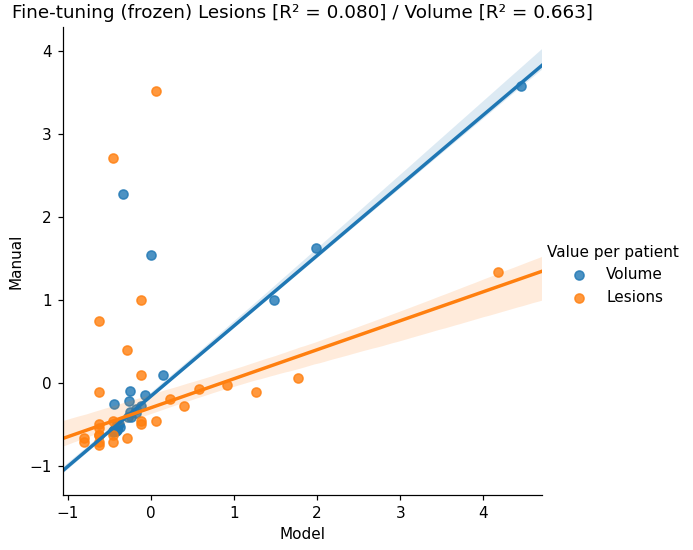

<IPython.core.display.Javascript object>


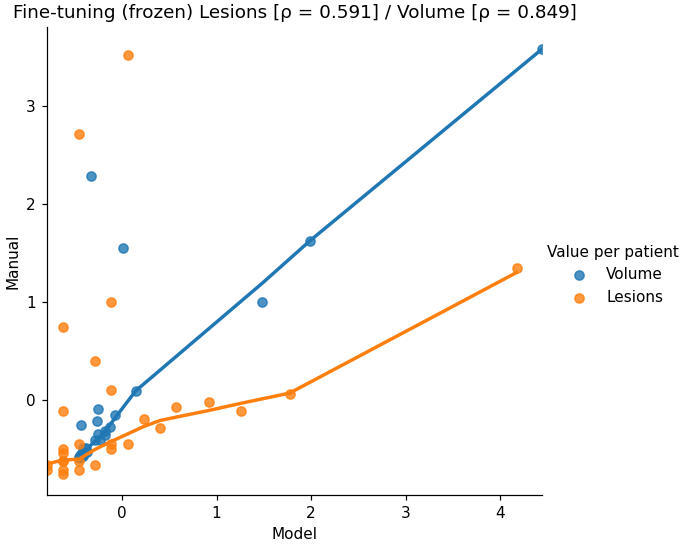

<IPython.core.display.Javascript object>


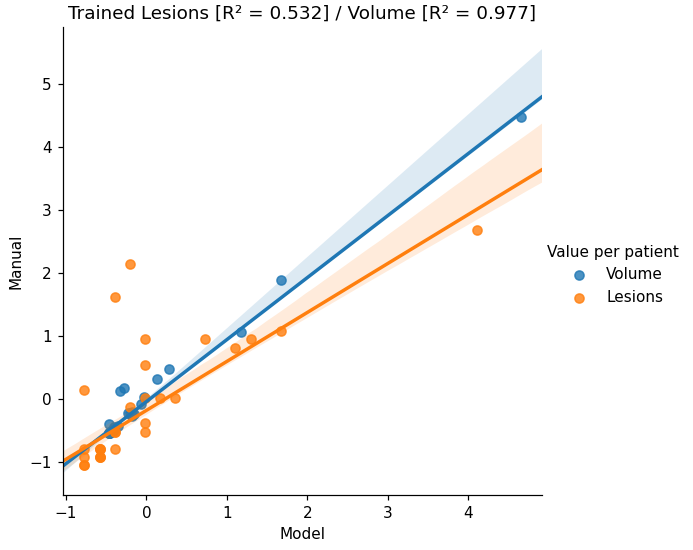

<IPython.core.display.Javascript object>


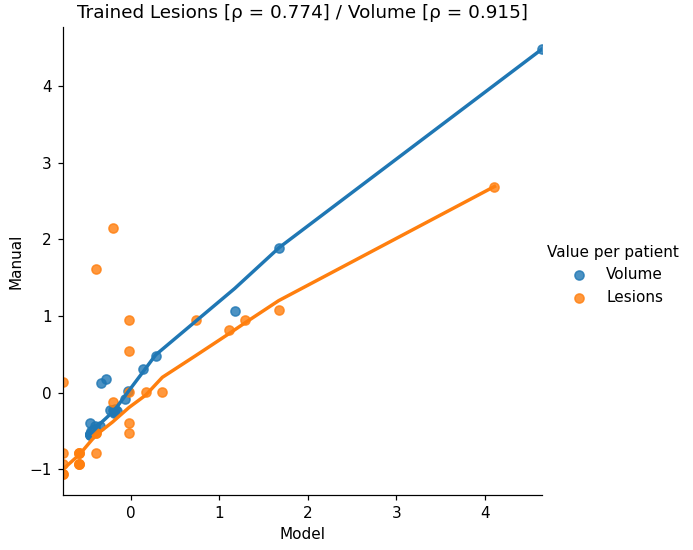

<IPython.core.display.Javascript object>


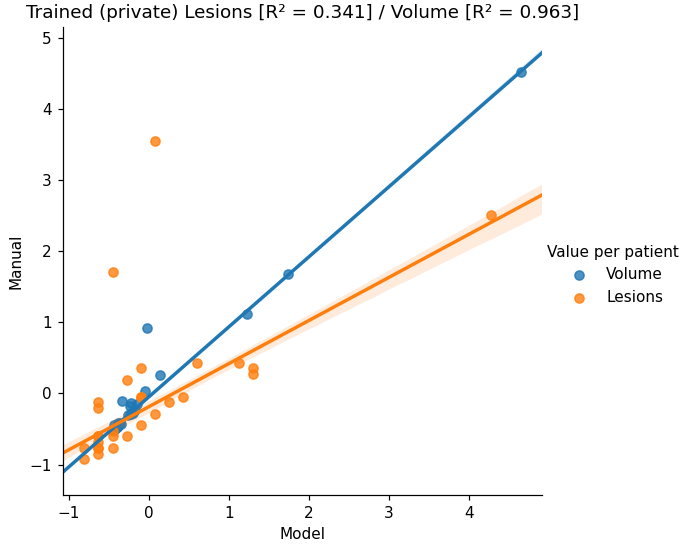

<IPython.core.display.Javascript object>


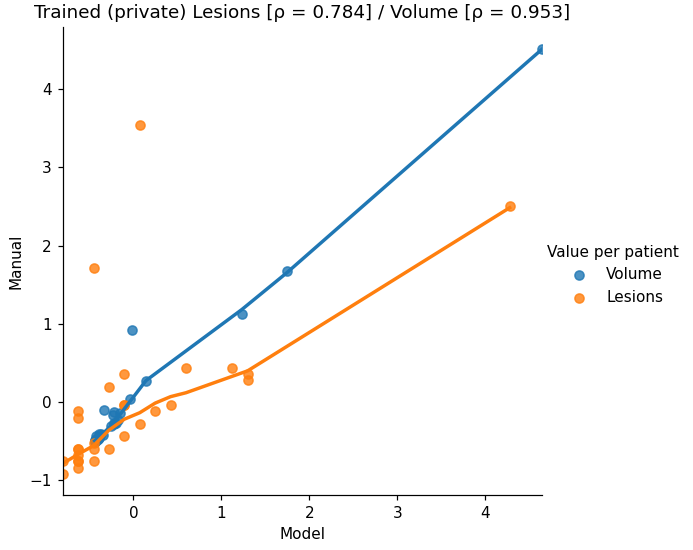

In [20]:
plot_correlation(all_metrics, 'Baseline')
plot_correlation(all_metrics, 'Baseline', lowess=True)
plot_correlation(all_metrics, 'Fine-tuning')
plot_correlation(all_metrics, 'Fine-tuning', lowess=True)
plot_correlation(all_metrics, 'Fine-tuning (frozen)')
plot_correlation(all_metrics, 'Fine-tuning (frozen)', lowess=True)
plot_correlation(all_metrics, 'Trained')
plot_correlation(all_metrics, 'Trained', lowess=True)
plot_correlation(all_metrics, 'Trained (private)')
plot_correlation(all_metrics, 'Trained (private)', lowess=True)